# Feature Engineering

For reference, I'm going to go into a bit more detail on the feature engineering. 
We will engineer features based on the human classification to find those features that predict the
observed properties of the light curves best.

There are two parts to feature engineering:
1. using cross validation to gauge what effect certain hyperparameters have on the final classification
2. comparing various features against each other and how effective they actually are in classification.

We'll do 1 first, then 2. 

## Setting Hyperparameters

If we restrict ourselves to summary statistics (rather than using 2D histograms of hardness ratios and/or 
full/binned periodograms), there are only a few hyperparameters left:

- the duration of a segment
- the overlap between consecutive segments
- the number of time bins used in the linear filter
- the time binning (if any) in the linear filter
- the regularization parameter in the linear filter

We will incorporate all of this into a pipeline and cross-validate across a bunch 
of parameters to find out how well we can predict the (human-classified) data from
linear filter weights + a random forest alone.



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook", font_scale=2.5, rc={"axes.labelsize": 26})
plt.rc("font", size=24, family="serif", serif="Computer Sans")
plt.rc("axes", titlesize=20, labelsize=20) 
plt.rc("text", usetex=True)

import numpy as np
import cPickle as pickle
from pandas.tools.plotting import scatter_matrix
import pandas as pd


import powerspectrum
import generaltools as gt
import feature_extraction
#import grs1915_utils

import glob
import scipy.stats

#import sys

#sys.path.append("/Users/danielahuppenkothen/work/repositories/LightEcho/code/")

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import KFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation



import linearfilter

You don't have jplephread and jplephinterp! You can't do barycentering like this!


/scratch/daniela/sw/miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


First, let's load the data and split it into training, test and validation sets:

In [2]:
f = open("../../grs1915_all_125ms.dat")
d_all = pickle.load(f)
f.close()

## total number of light curves
n_lcs = len(d_all)

## Set the seed to I will always pick out the same light curves.
np.random.seed(20150608)

## shuffle list of light curves
np.random.shuffle(d_all)

train_frac = 0.6
validation_frac = 0.2
test_frac = 0.2

## let's pull out light curves for three data sets into different variables.
d_all_train = d_all[:int(train_frac*n_lcs)]
d_all_val = d_all[int(train_frac*n_lcs):int((train_frac + validation_frac)*n_lcs)]
d_all_test = d_all[int((train_frac + validation_frac)*n_lcs):]

Next, we'll extract segments of a given length:

In [3]:
seg_length_supervised = 1024.
seg_length_unsupervised = 256.

overlap_all = 64.

## CURRENTLY RUNNING LONG SEGMENTS FOR SUPERVISED CLASSIFICATION
seg_train, labels_train = feature_extraction.extract_segments(d_all_train, seg_length=seg_length_supervised, overlap=overlap_all)
seg_val, labels_val = feature_extraction.extract_segments(d_all_val, seg_length=seg_length_unsupervised, overlap=overlap_all)
seg_test, labels_test = feature_extraction.extract_segments(d_all_test, seg_length=seg_length_unsupervised, overlap=overlap_all)


We're going to use the data that's been classified *only* for this task, so we'll need to extract it.
In practice, this means throwing away all samples for which the label is `None`.

In [4]:
seg_class_train = np.array(seg_train)[labels_train != "None"]
labels_class_train = labels_train[labels_train != "None"]

seg_class_val = np.array(seg_val)[labels_val != "None"]
labels_class_val = labels_val[labels_val != "None"]

seg_class_test = np.array(seg_test)[labels_test != "None"]
labels_class_test = labels_test[labels_test != "None"]


Next, we're going to need to extract the counts only from the segments, then scale them to a mean of zero and unit variance:

In [5]:
seg_class_train.shape

(3340, 8192, 5)

In [6]:
counts_train = np.array([s[:,1] for s in seg_class_train])
counts_scaled_train = StandardScaler().fit_transform(counts_train.T).T

counts_val = np.array([s[:,1] for s in seg_class_val])
counts_scaled_val = StandardScaler().fit_transform(counts_val.T).T

counts_test = np.array([s[:,1] for s in seg_class_test])
counts_scaled_test = StandardScaler().fit_transform(counts_test.T).T



In order to use it in a pipeline and do the cross-validation in any useful way, 
we're going to need to define teh rebinning of the light curve in a way that scikit-learn 
can parse, i.e. as a transformer class. This is kind of stupidly simple, but it'll come in handy.


In [7]:
class RebinTimeseries(BaseEstimator, TransformerMixin):

    def __init__(self, n=4, method="average"):

        """
        Initialize hyperparameters

        :param n: number of samples to bin
        :param method: "average" or "sum" the samples within a bin?
        :return:
        """

        self.n = n ## save number of bins to average together
        self.method = method

        return



    def fit(self,X):
        """
        I don't really need a fit method!
        """
        
        ## set number of light curves (L) and 
        ## number of samples per light curve (k)
        return self
        
        
    def transform(self, X):
        self.L, self.K = X.shape

    
        ## set the number of binned samples per light curve
        K_binned = int(self.K/self.n)
        
        ## if the number of samples in the original light curve
        ## is not divisible by n, then chop off the last few samples of 
        ## the light curve to make it divisible
        #print("X shape: " + str(X.shape))

        if K_binned*self.n < self.K:
            X = X[:,:self.n*K_binned]
        
        ## the array for the new, binned light curves
        X_binned = np.zeros((self.L, K_binned))
        
        if self.method in ["average", "mean"]:
            method = np.mean
        elif self.method == "sum":
            method = np.sum
        else:
            raise Exception("Method not recognized!")
        
        #print("X shape: " + str(X.shape))
        #print("L: " + str(self.L))
        for i in xrange(self.L):
            t_reshape = X[i,:].reshape((K_binned, self.n))
            X_binned[i,:] = method(t_reshape, axis=1)
        
        return X_binned


    def predict(self, X):
        pass
    
    def score(self, X):
        pass

    def fit_transform(self, X, y=None):

        self.fit(X)
        X_binned = self.transform(X)

        return X_binned


Let's try it on just a few light curves:

In [8]:
counts_test = counts_scaled_train[:10]
counts_test.shape

(10, 8192)

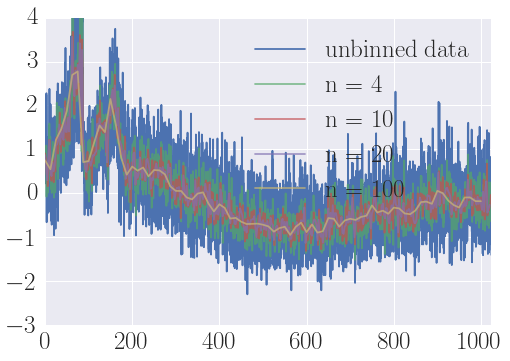

In [9]:
n_all = [4, 10, 20, 100]

plt.plot(np.arange(len(counts_test[0]))*0.125, counts_test[0], label="unbinned data")

for n in n_all:
    rt = RebinTimeseries(n=n, method="average")
    counts_binned = rt.fit_transform(counts_test)
    plt.plot(np.arange(len(counts_binned[0]))*0.125*n, counts_binned[0], alpha=0.7, label="n = %i"%n)
    
plt.axis([0,1024., -3, 4])
plt.legend()

Seems to work! We can now use this for our pipeline!

**NOTE: DO I NEED TO RESCALE THE REBINNED DATA? NOT SURE!**

In [12]:
## set the estimators to glue together:
## first is the Echo State Network, then a Random Forest Classifier to do the classification
rt = RebinTimeseries(method="average")
lf = linearfilter.LinearFilterEnsemble()
#esn = EchoStateEnsemble(n_washout=100, scaling=1.0, lamb=1.e-4, topology="scr")
rfc = RandomForestClassifier(n_estimators=300)

## Create the pipeline
pipe = Pipeline(steps=[("rt", rt),('lf', lf), ('rfc', rfc)])


## parameters to search using GridSearchCV
n = [1,4,8,16,50,80] ## number of samples to rebin
k = [10,15,20,30,40,50,70,90] ## number of weights in the linear filter
lamb = [0.01,0.1,1.0, 10.] ## regularization parameter for ridge regression
max_depth = [10,20,30,40,50,100,200,500] ## maximum depth of Random Forest

## instantiate GridSearchCV with the pipeline and a dictionary with the parameters
## 5-fold cross-validation
estimator = GridSearchCV(pipe,
                         dict(rt__n=n,
                              lf__k = k,
                              lf__lamb = lamb,
                              rfc__max_depth=max_depth), cv=None, verbose=3, n_jobs=20)

## fit and cross-validate
estimator.fit(counts_scaled_train, labels_class_train)

Fitting 3 folds for each of 1536 candidates, totalling 4608 fits
[CV] lf__lamb=1.0, rfc__max_depth=200, lf__k=10, rt__n=4 .............

[CV] lf__lamb=1.0, rfc__max_depth=100, lf__k=10, rt__n=8 .............
[CV] lf__lamb=10.0, rfc__max_depth=50, lf__k=10, rt__n=160 ...........
[CV] lf__lamb=1.0, rfc__max_depth=500, lf__k=10, rt__n=160 ...........
[CV] lf__lamb=10.0, rfc__max_depth=10, lf__k=10, rt__n=8 .............
[CV] lf__lamb=10.0, rfc__max_depth=100, lf__k=10, rt__n=4 ............
[CV]  lf__lamb=1.0, rfc__max_depth=20, lf__k=10, rt__n=16, score=0.568243 -   4.5s
[CV]  lf__lamb=1.0, rfc__max_depth=30, lf__k=10, rt__n=8, score=0.593863 -   5.9s[CV]  lf__lamb=10.0, rfc__max_depth=10, lf__k=10, rt__n=80, score=0.537004 -   3.0s
[CV] lf__lamb=10.0, rfc__max_depth=30, lf__k=10, rt__n=1 .............

[CV] lf__lamb=10.0, rfc__max_depth=40, lf__k=10, rt__n=16 ............

[CV] lf__lamb=1.0, rfc__max_depth=100, lf__k=10, rt__n=8 .............

[CV]  lf__lamb=1.0, rfc__max_depth=20, lf__k

[Parallel(n_jobs=20)]: Done  32 jobs       | elapsed:   10.0s
[Parallel(n_jobs=20)]: Done   1 jobs       | elapsed:   28.0s
[Parallel(n_jobs=20)]: Done 128 jobs       | elapsed:  1.3min
[Parallel(n_jobs=20)]: Done 288 jobs       | elapsed:  2.1min
[Parallel(n_jobs=20)]: Done 512 jobs       | elapsed:  3.8min
[Parallel(n_jobs=20)]: Done 800 jobs       | elapsed:  6.1min
[Parallel(n_jobs=20)]: Done 1152 jobs       | elapsed:  8.9min
[Parallel(n_jobs=20)]: Done 1568 jobs       | elapsed: 13.2min
[Parallel(n_jobs=20)]: Done 2048 jobs       | elapsed: 17.5min
[Parallel(n_jobs=20)]: Done 2592 jobs       | elapsed: 24.1min
[Parallel(n_jobs=20)]: Done 3200 jobs       | elapsed: 33.0min
[Parallel(n_jobs=20)]: Done 3872 jobs       | elapsed: 45.8min
[Parallel(n_jobs=20)]: Done 4608 out of 4608 | elapsed: 62.0min finished


[CV]  lf__lamb=1.0, rfc__max_depth=50, lf__k=30, rt__n=80, score=0.404332 -   4.9s[CV] lf__lamb=0.1, rfc__max_depth=500, lf__k=30, rt__n=160 ...........
[CV] lf__lamb=1.0, rfc__max_depth=500, lf__k=30, rt__n=50 ............
[CV] lf__lamb=0.01, rfc__max_depth=10, lf__k=10, rt__n=1 .............
[CV] lf__lamb=0.01, rfc__max_depth=10, lf__k=10, rt__n=1 .............
[CV] lf__lamb=0.01, rfc__max_depth=10, lf__k=10, rt__n=1 .............
[CV] lf__lamb=0.01, rfc__max_depth=10, lf__k=10, rt__n=4 .............
[CV] lf__lamb=0.01, rfc__max_depth=10, lf__k=10, rt__n=4 .............
[CV] lf__lamb=0.01, rfc__max_depth=10, lf__k=10, rt__n=4 .............
[CV] lf__lamb=0.01, rfc__max_depth=10, lf__k=10, rt__n=8 .............
[CV] lf__lamb=0.01, rfc__max_depth=10, lf__k=10, rt__n=8 .............
[CV] lf__lamb=0.01, rfc__max_depth=10, lf__k=10, rt__n=8 .............
[CV] lf__lamb=0.01, rfc__max_depth=10, lf__k=10, rt__n=16 ............
[CV] lf__lamb=0.01, rfc__max_depth=10, lf__k=10, rt__n=16 ........

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('rt', RebinTimeseries(method='average', n=4)), ('lf', LinearFilterEnsemble(k=100, lamb=None)), ('rfc', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=20,
       param_grid={'lf__lamb': [0.01, 0.1, 1.0, 10.0], 'rfc__max_depth': [10, 20, 30, 40, 50, 100, 200, 500], 'lf__k': [10, 15, 20, 30, 40, 50, 70, 90], 'rt__n': [1, 4, 8, 16, 50, 80]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=3)

[CV] lf__lamb=0.01, rfc__max_depth=30, lf__k=10, rt__n=8 .............
[CV] lf__lamb=0.01, rfc__max_depth=30, lf__k=10, rt__n=1 .............
[CV] lf__lamb=0.01, rfc__max_depth=30, lf__k=10, rt__n=1 .............
[CV] lf__lamb=0.01, rfc__max_depth=50, lf__k=10, rt__n=50 ............
[CV] lf__lamb=0.01, rfc__max_depth=30, lf__k=10, rt__n=50 ............
[CV] lf__lamb=0.01, rfc__max_depth=30, lf__k=10, rt__n=8 .............
[CV] lf__lamb=0.01, rfc__max_depth=500, lf__k=10, rt__n=16 ...........
[CV] lf__lamb=0.01, rfc__max_depth=100, lf__k=10, rt__n=8 ............
[CV]  lf__lamb=10.0, rfc__max_depth=200, lf__k=20, rt__n=16, score=0.605761 -   5.3s
[CV]  lf__lamb=0.1, rfc__max_depth=20, lf__k=30, rt__n=8, score=0.621962 -   8.4s[CV] lf__lamb=10.0, rfc__max_depth=500, lf__k=20, rt__n=80 ...........

[CV] lf__lamb=10.0, rfc__max_depth=500, lf__k=20, rt__n=50 ...........
[CV]  lf__lamb=10.0, rfc__max_depth=40, lf__k=20, rt__n=16, score=0.617329 -   5.3s[CV]  lf__lamb=0.1, rfc__max_depth=50, l

In [28]:
best_estimator = estimator.best_estimator_
best_score = estimator.best_score_
best_params = estimator.best_params_

[CV]  lf__lamb=10.0, rfc__max_depth=100, lf__k=40, rt__n=80, score=0.490633 -   5.2s[CV] lf__lamb=0.1, rfc__max_depth=100, lf__k=50, rt__n=80 ............

[CV] lf__lamb=10.0, rfc__max_depth=200, lf__k=40, rt__n=50 ...........
[CV] lf__lamb=0.01, rfc__max_depth=50, lf__k=50, rt__n=1 .............


[CV] lf__lamb=0.01, rfc__max_depth=40, lf__k=50, rt__n=4 .............
[CV]  lf__lamb=1.0, rfc__max_depth=500, lf__k=50, rt__n=80, score=0.342934 -   6.3s[CV]  lf__lamb=0.01, rfc__max_depth=30, lf__k=50, rt__n=8, score=0.644068 -  11.7s
[CV]  lf__lamb=10.0, rfc__max_depth=50, lf__k=40, rt__n=50, score=0.542373 -   5.5s
[CV] lf__lamb=1.0, rfc__max_depth=20, lf__k=50, rt__n=4 ..............[CV] lf__lamb=0.01, rfc__max_depth=30, lf__k=50, rt__n=4 .............


[CV] lf__lamb=0.1, rfc__max_depth=40, lf__k=50, rt__n=16 .............
[CV] lf__lamb=1.0, rfc__max_depth=20, lf__k=50, rt__n=1 ..............


[CV] lf__lamb=1.0, rfc__max_depth=40, lf__k=40, rt__n=50 .............[CV] lf__lamb=1.0, rfc

In [33]:
estimator.verbose = 0
best_estimator = estimator.best_estimator_
best_score = estimator.best_score_
best_params = estimator.best_params_

print("The best cross-validation score of %.3f was achieved for parameters "%best_score + str(best_params))

The best cross-validation score of 0.714 was achieved for parameters {'lf__lamb': 10.0, 'rfc__max_depth': 50, 'lf__k': 10, 'rt__n': 1}


In [34]:
print("The validation score for the best model is " + str(best_estimator.score(counts_scaled_val, labels_class_val)))

The validation score for the best model is 0.449110671937


We find the best cross-validation score for a model with 
    - $k = 10$ for the linear model
    - $\lambda = 10$ for the regularization of the linear model
    - $n = 1$, i.e. no binning of the light curves
    - a maximum depth of 50 for the Random Forest
    
We can now use this information to extract features. 
We will extract summary statistics for segments of 1024s and 256s duration as 
well as the weights of a linear model as features. 

In [38]:
import feature_extraction
datadir="../../"
feature_extraction.extract_all(d_all, seg_length_all=[seg_length_unsupervised, seg_length_supervised], 
                               overlap=overlap_all, val=True, train_frac=0.5, validation_frac = 0.25, 
                               test_frac = 0.25, k=10, lamb=10, datadir=datadir)

256 segments, summary
I am about to make a dictionary
<built-in method keys of dict object at 0x7f02df15b4b0>
I am in lc
I am in hr
I am about to make a dictionary
<built-in method keys of dict object at 0x7f02df15b050>
I am in lc
I am in hr
len(tstart_train): 31251
len(features_train): 3
len(tstart_test): 15359
len(features_test): 4
Checking for NaN in the training set ...
Checking for NaN in the test set ...
NaN in cov
I am about to make a dictionary
<built-in method keys of dict object at 0x7f02df4e86e0>
I am in lc
I am in hr
NaN in sample row 7563
Checking for NaN in the validation set ...
1024 segments, summary
I am about to make a dictionary
<built-in method keys of dict object at 0x7f02df4e86e0>
I am in lc
I am in hr
I am about to make a dictionary
<built-in method keys of dict object at 0x7f02df15b398>
I am in lc
I am in hr
len(tstart_train): 16181
len(features_train): 3
len(tstart_test): 8741
len(features_test): 4
Checking for NaN in the training set ...
Checking for NaN in th

Now we can use our feature vector to actually determine what the *most descriptive* features are. 

## Finding the most descriptive features
I'm going to start with all of the summary features and use a greedy approach: out of all summary features, which is the one that alone predicts the human classification best? I am going to keep that, and then add a second feaure, again going through the entire list of left-over features to figure out the best combination of two, and so on, until I reach the end of the 13 features. 

In the second step, I can add feature sets like the entire heatmap of the hardness diagram, or the periodogram to the game, but we'll keep it simple(ish) with the summary features only for now.

For this task, I'm going to use Random Forests, because I have to pick an algorithm and this one seems to be pretty robust.

In [40]:
features_train_full = np.loadtxt(datadir+"grs1915_%is_features_train.txt"%seg_length_supervised)
features_test_full = np.loadtxt(datadir+"grs1915_%is_features_test.txt"%seg_length_supervised)
features_val_full = np.loadtxt(datadir+"grs1915_%is_features_val.txt"%seg_length_supervised)

labels_test_full = np.array(gt.conversion(datadir+"grs1915_%is_labels_test.txt"%seg_length_supervised)[0])
labels_train_full = np.array(gt.conversion(datadir+"grs1915_%is_labels_train.txt"%seg_length_supervised)[0])
labels_val_full = np.array(gt.conversion(datadir+"grs1915_%is_labels_val.txt"%seg_length_supervised)[0])

tstart_train_full = np.loadtxt(datadir+"grs1915_%is_tstart_train.txt"%seg_length_supervised)
tstart_test_full = np.loadtxt(datadir+"grs1915_%is_tstart_test.txt"%seg_length_supervised)
tstart_val_full = np.loadtxt(datadir+"grs1915_%is_tstart_val.txt"%seg_length_supervised)

features_all_full = np.concatenate((features_train_full, features_val_full, features_test_full))

features_train = features_train_full[np.where(labels_train_full != "None")]
features_test = features_test_full[np.where(labels_test_full != "None")]
features_val= features_val_full[np.where(labels_val_full != "None")]

labels_train= labels_train_full[np.where(labels_train_full != "None")]
labels_test = labels_test_full[np.where(labels_test_full != "None")]
labels_val = labels_val_full[np.where(labels_val_full != "None")]


In [41]:
print("There are %i training samples with %i features"%features_train.shape)
print("There are %i validation samples with %i features"%features_val.shape)
print("There are %i test samples with %i features"%features_test.shape)


There are 2627 training samples with 31 features
There are 1741 validation samples with 31 features
There are 1540 test samples with 31 features


The features here are:
* mean count rate
* median count rate
* total variance in the count rate
* skew of the countrate
* kurtosis of the count rate
* Frequency where the PSD has its maximum
* Power Spectral Band A
* Power Spectral Band B
* Power Spectral Band C
* Power Spectral Band D
* Power Spectral Color 1 (PSDc/PSDa)
* Power Spectral Color 2 (PSDb/PSDd)
* mean of hardness ratio HR1
* mean of hardness ratio HR2
* flattened covariance matrix of HR1 and HR2
* skew of HR1 and HR2
* kurtosis of HR1 and HR2
* 10 weights from the linear filter

for a total of 31 features.

In [42]:

score = []
best_params = []
## first feature
for i in range(features_train.shape[1]):
    ft = np.atleast_2d(features_train[:,i]).T
    fv = np.atleast_2d(features_val[:,i]).T

    ### scale features
    scaler_train = StandardScaler().fit(ft)
    fscaled_train = scaler_train.transform(ft)
    #print(fscaled_train.shape)
    
    scaler_val = StandardScaler().fit(fv)
    fscaled_val = scaler_val.transform(fv)
    
    ### Random Forest Classifier
    params = {'max_depth': [5,6,7,10,12,15,20,50,100,200]}#,
    grid_rfc = GridSearchCV(RandomForestClassifier(n_estimators=300), param_grid=params,
                            verbose=0, n_jobs=10)

    grid_rfc.fit(fscaled_train, labels_train)
    print("Best results for the Random Forest run:")
    print("Best parameter: " + str(grid_rfc.best_params_))
    best_params.append(grid_rfc.best_params_)
    print("Training accuracy: " + str(grid_rfc.score(fscaled_train, labels_train)))
    print("Validation accuracy: " + str(grid_rfc.score(fscaled_val, labels_val)))
    score.append(grid_rfc.score(fscaled_val, labels_val))


Best results for the Random Forest run:
Best parameter: {'max_depth': 5}
Training accuracy: 0.631518842786
Validation accuracy: 0.364158529581
Best results for the Random Forest run:
Best parameter: {'max_depth': 5}
Training accuracy: 0.593071945185
Validation accuracy: 0.31303848363
Best results for the Random Forest run:
Best parameter: {'max_depth': 6}
Training accuracy: 0.698515416825
Validation accuracy: 0.259620907524
Best results for the Random Forest run:
Best parameter: {'max_depth': 5}
Training accuracy: 0.43966501713
Validation accuracy: 0.240666283745
Best results for the Random Forest run:
Best parameter: {'max_depth': 5}
Training accuracy: 0.390178911306
Validation accuracy: 0.305571510626
Best results for the Random Forest run:
Best parameter: {'max_depth': 5}
Training accuracy: 0.537495241721
Validation accuracy: 0.366456059736
Best results for the Random Forest run:
Best parameter: {'max_depth': 5}
Training accuracy: 0.523030072326
Validation accuracy: 0.117174037909
B

In [46]:
max_ind = np.where(score == np.max(score))[0]
max_score = score[max_ind]
print("The maximum validation score of %.3f was achieved for feature %i"%(max_score, max_ind))

The maximum validation score of 0.366 was achieved for feature 5


It looks like on the first try, the frequency where the PSD has its maximum does best in predicting the human classification on the validation set. Let's now automate this process for the rest of the features.

In [50]:
score_all = []
feature_ranking = []
nfeatures = range(features_train.shape[1])
features_new_train = []
features_new_val = []
features_new_test = []
best_params_all = []

for i in range(features_train.shape[1]):
    print("I am on the %ith loop"%i)
    score = []
    best_params = []
    ## first feature
    for j in nfeatures:
        if j in feature_ranking:
            continue
        #print("I am on feature %i"%j)
        if len(features_new_train) == 0:
            ft = np.atleast_2d(features_train[:,j]).T
            fv = np.atleast_2d(features_val[:,j]).T
            fte = np.atleast_2d(features_test[:,j]).T
        else:
            ft = np.concatenate((features_new_train, ft), 1)
            fv = np.concatenate((features_new_val, fv), 1)
            fte = np.concatenate((features_new_test, fte), 1)
        ### scale features
        f_all = np.concatenate((ft, fv, fte))
        #print("NaN in row: " + str(np.where(np.isnan(f_all))))
        scaler_train = StandardScaler().fit(f_all)
        fscaled_train = scaler_train.transform(ft)
        
        fscaled_val = scaler_train.transform(fv)
        ### Random Forest Classifier
        params = {'max_depth': [5,10,20,50,100,200,400]}#,
        grid_rfc = GridSearchCV(RandomForestClassifier(n_estimators=250), param_grid=params,
                                verbose=0, n_jobs=4)
        grid_rfc.fit(fscaled_train, labels_train)
        best_params.append(grid_rfc.best_params_)
        score.append(grid_rfc.score(fscaled_val, labels_val))
    
    score_all.append(score)
    best_params_all.append(best_params)
    best_ind = np.where(score == np.max(score))[0]
    print("best_ind: " + str(best_ind))
    if len(best_ind) > 1:
        best_ind = best_ind[0]
    print("The best score in round " + str(i) + " is " + str(np.max(score)))
    n_best = nfeatures.pop(best_ind)
    print("The best-ranked feature in round " + str(i) + " is " + str(n_best))
    feature_ranking.append(n_best)
    if len(features_new_train) == 0:
        features_new_train = np.atleast_2d(features_train[:,n_best]).T
        features_new_val = np.atleast_2d(features_val[:,n_best]).T
        features_new_test = np.atleast_2d(features_test[:,n_best]).T
    else:
        features_new_train = np.concatenate((features_new_train, np.atleast_2d(features_train[:,n_best]).T), 1)
        features_new_val = np.concatenate((features_new_val, np.atleast_2d(features_val[:,n_best]).T), 1)
        features_new_test = np.concatenate((features_new_test, np.atleast_2d(features_test[:,n_best]).T), 1)


I am on the 0th loop
best_ind: [5]
The best score in round 0 is 0.470993681792
The best-ranked feature in round 0 is 5
I am on the 1th loop
best_ind: [1]
The best score in round 1 is 0.537622056289
The best-ranked feature in round 1 is 1
I am on the 2th loop
best_ind: [2]
The best score in round 2 is 0.673750717978
The best-ranked feature in round 2 is 3
I am on the 3th loop
best_ind: [6]
The best score in round 3 is 0.67777139575
The best-ranked feature in round 3 is 9
I am on the 4th loop
best_ind: [20]
The best score in round 4 is 0.723147616312
The best-ranked feature in round 4 is 24
I am on the 5th loop
best_ind: [21]
The best score in round 5 is 0.727168294084
The best-ranked feature in round 5 is 26
I am on the 6th loop
best_ind: [7]
The best score in round 6 is 0.708213670304
The best-ranked feature in round 6 is 11
I am on the 7th loop
best_ind: [16]
The best score in round 7 is 0.724870763929
The best-ranked feature in round 7 is 21
I am on the 8th loop
best_ind: [16]
The be

KeyboardInterrupt: 

In [13]:
## Print the indices of the original feature vector by importance
print(feature_ranking)

[12, 1, 6, 17, 11, 9, 20, 13, 14, 8, 16, 15, 7, 3, 0, 19, 4, 18, 2, 10, 5]


Ranked features:

0. Covariance Matrix of the HR ratios (13 = [01])
1. Power Spectral Color 1 (PSDc/PSDa)
2. total variance in the count rate
3. Frequency where the PSD has its maximum
4. median count rate
5. Power Spectral Color 2 (PSDb/PSDd
6. mean of hardness ratio HR2
7. Power Spectral Band A
8. Covariance Matrix of the HR ratios (12 = [00])
9. mean count rate
10. Covariance Matrix of the HR ratios (15 = [11])
11. Covariance Matrix of the HR ratios (14 = [10])
12. Power Spectral Band D
13. mean of hardness ratio HR1
14. Power Spectral Band C
15. Power Spectral Band B
 

There's a mix of all features (hardness ratios, power spectral, overall time series) here, which means that all components seem to be fairly important to the classification. Especially the fact that the hardness ratio features (in particular the covariance between them) plays a role might mean we might want to think about features that captures the covariance better.


In [14]:
# Find the maximum of the validation scores for each run.
score_max_all = np.array([np.max(s) for s in score_all])
print(score_max_all)

[ 0.50178699  0.5582559   0.68977841  0.76483202  0.77626876  0.82344532
  0.83988563  0.84274482  0.8470336   0.84989278  0.84989278  0.85918513
  0.85775554  0.84846319  0.85847034  0.85346676  0.85346676  0.8470336
  0.8470336   0.8470336   0.84917798]


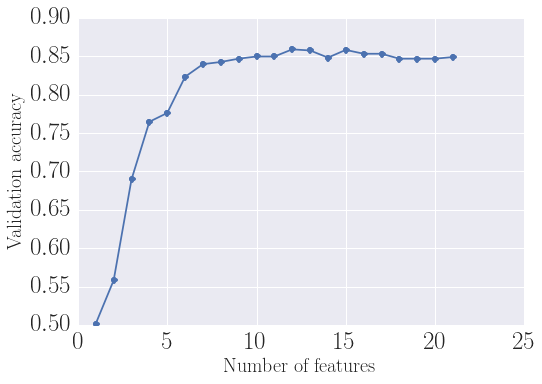

In [15]:
## plot the validation fraction versus the number of features in the classification
plt.plot(np.arange(len(score_max_all))+1., score_max_all, "o-")
plt.xlabel("Number of features")
plt.ylabel("Validation accuracy")

The validation fraction seems to saturate at about 77%.
It's not clear whether this means
- there's too little data
- the human classification just sucks
- the features don't accurately encapsulate the various behaviours in the data (e.g. QPOs)

Let's print a confusion matrix for the run (1) with all features (2) with only 12 features.


In [16]:
best_params_all[-1]

[{'max_depth': 400}]

In [19]:
nfeatures = 12
features_new_all = np.concatenate((features_new_train, features_new_val, features_new_test))

scaler_train = StandardScaler().fit(features_new_all)
fscaled_train = scaler_train.transform(features_new_train)
fscaled_val = scaler_train.transform(features_new_val)
fscaled_test = scaler_train.transform(features_new_test)

rfc_full = RandomForestClassifier(n_estimators=500, max_depth=10)
rfc_full.fit(fscaled_train, labels_train)

#grid_rfc.fit(fscaled_train, labels_train)
print("Training accuracy: " + str(rfc_full.score(fscaled_train, labels_train)))
print("Validation accuracy: " + str(rfc_full.score(fscaled_val, labels_val)))

labels_rfc_full = rfc_full.predict(fscaled_val)
labels_rfc_full_test = rfc_full.predict(fscaled_test)


features_new_red = np.concatenate((features_new_train[:,:nfeatures], features_new_val[:,:nfeatures], features_new_test[:,:nfeatures]))

scaler_train = StandardScaler().fit(features_new_red)
fscaled_train = scaler_train.transform(features_new_train[:,:nfeatures])
fscaled_val = scaler_train.transform(features_new_val[:,:nfeatures])
fscaled_test = scaler_train.transform(features_new_test[:,:nfeatures])

rfc_red = RandomForestClassifier(n_estimators=500, max_depth=400)
rfc_red.fit(fscaled_train, labels_train)
print("Training accuracy: " + str(rfc_red.score(fscaled_train, labels_train)))
print("Validation accuracy: " + str(rfc_red.score(fscaled_val, labels_val)))

labels_rfc_red = rfc_red.predict(fscaled_val)
labels_rfc_red_test = rfc_red.predict(fscaled_test)


Training accuracy: 0.997902684564
Validation accuracy: 0.865618298785
Training accuracy: 1.0
Validation accuracy: 0.84345961401


8013

Let's plot confusion matrices for both runs. 

[[ 27   5   0   2   0   2   0   0   0   0   0   0   0   0   0]
 [  0  96   0   0   0   0   0   0   0   3   3   0   0   0   0]
 [  0   0  83   0   0   8   0   0   0   0   0   0   0   0   0]
 [  0   0   0 268   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  25  57   0   0   0   0   0   0   0   0   0   0]
 [  0   1  18  11   0 157   0   0   0   0   0   3   0   0   0]
 [  0   6   0   0   0   0  36  62   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 139   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  20   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  42   0   0   0   0   0]
 [  2  13   0   0   0   0   0   0   0   2  74   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  30   0   0   0]
 [  0   0   0   0   0   0   1   0   0   0   0   0 108   0   0]
 [  0   0   0   0   0   0   0   0   2   0   1   0   0  19   0]
 [  2  14   0   0   0   1   0   0   0   1   0   0   0   0  55]]
[[ 26   5   0   4   0   1   0   0   0   0   0   0   0 

([<matplotlib.axis.YTick at 0x11ae0b190>,
 <a list of 15 Text yticklabel objects>)

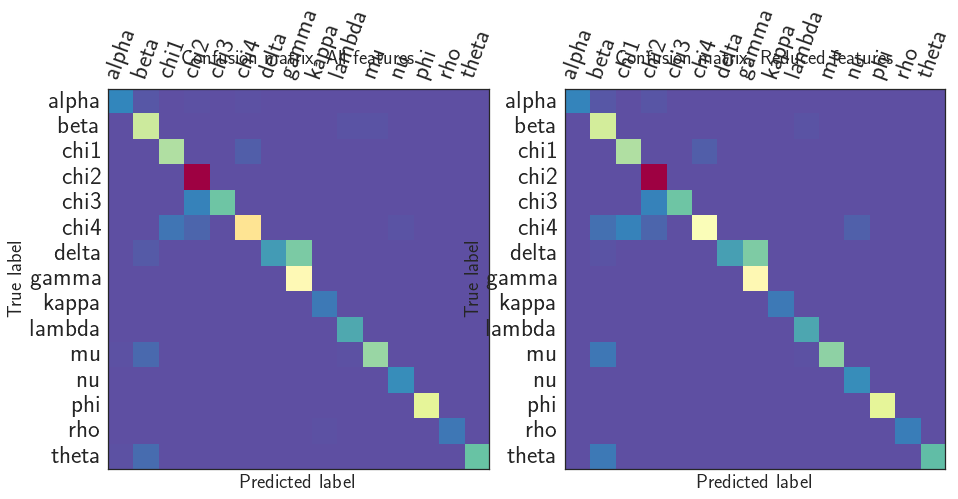

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.cm as cmap

fig = plt.figure(figsize=(15,15))

sns.set_style("white") 
unique_labels = np.unique(labels_test)
cm = confusion_matrix(labels_val, labels_rfc_full, labels=unique_labels)
print(cm)
#print(unique_labels)
ax1 = fig.add_subplot(121)
ax1.matshow(cm, cmap=cmap.Spectral_r )
ax1.set_title('Confusion matrix, All features')
#plt.colorbar()
ax1.set_ylabel('True label')
ax1.set_xlabel('Predicted label')
plt.xticks(range(len(unique_labels)), unique_labels, rotation=70)
plt.yticks(range(len(unique_labels)), unique_labels)
#plt.show()


#ax2 = fig.add_subplot(222)
#sns.set_style("white") 
#unique_labels = np.unique(labels_val)
#cm = confusion_matrix(labels_test, labels_rfc_full_test, labels=unique_labels)
#ax2.matshow(cm, cmap=cmap.Spectral_r )
#ax2.set_title('Confusion matrix, All features, test set')
#ax2.set_ylabel('True label')
#ax2.set_xlabel('Predicted label')
#plt.xticks(range(len(unique_labels)), unique_labels, rotation=70)
#plt.yticks(range(len(unique_labels)), unique_labels)
#plt.show()


sns.set_style("white") 
unique_labels = np.unique(labels_val)
cm = confusion_matrix(labels_val, labels_rfc_red, labels=unique_labels)
print(cm)
#print(unique_labels)
ax3 = fig.add_subplot(122)
ax3.matshow(cm, cmap=cmap.Spectral_r )
ax3.set_title('Confusion matrix, Reduced features')
ax3.set_ylabel('True label')
ax3.set_xlabel('Predicted label')
plt.xticks(range(len(unique_labels)), unique_labels, rotation=70)
plt.yticks(range(len(unique_labels)), unique_labels)
#plt.show()


#ax4 = fig.add_subplot(224)
#sns.set_style("white") 
#unique_labels = np.unique(labels_test)
#cm = confusion_matrix(labels_test, labels_rfc_red_test, labels=unique_labels)
#ax4.matshow(cm, cmap=cmap.Spectral_r )
#ax4.set_title('Confusion matrix, Reduced features, test set')
#ax4.set_ylabel('True label')
#ax4.set_xlabel('Predicted label')
#plt.xticks(range(len(unique_labels)), unique_labels, rotation=70)
#plt.yticks(range(len(unique_labels)), unique_labels)
#plt.show()

There are differences in the confusion matrices between the full set of features and the reduced features, but between validation and test set confusions are similar, which is good!

Let's also plot the feature importances as derived from the trees:

Feature ranking, full feature vector:
1. feature 19 (0.081315)
2. feature 5 (0.079543)
3. feature 0 (0.076901)
4. feature 7 (0.074227)
5. feature 2 (0.067108)
6. feature 8 (0.061011)
7. feature 4 (0.058557)
8. feature 9 (0.057997)
9. feature 18 (0.054947)
10. feature 14 (0.049449)
11. feature 13 (0.045924)
12. feature 10 (0.044682)
13. feature 20 (0.043390)
14. feature 1 (0.042527)
15. feature 11 (0.042206)
16. feature 12 (0.037565)


AssertionError: incompatible sizes: argument 'height' must be length 16 or scalar

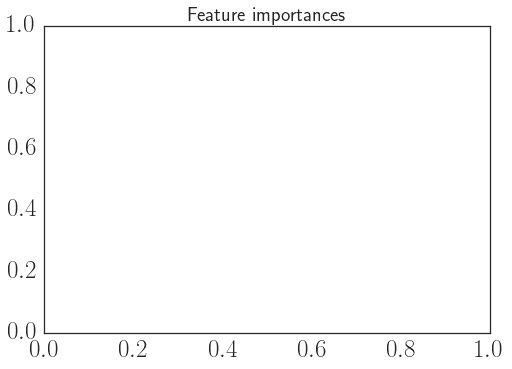

In [24]:
imp_rfc_full = rfc_full.feature_importances_
imp_rfc_red = rfc_red.feature_importances_

std_full = np.std([tree.feature_importances_ for tree in rfc_full.estimators_],
             axis=0)
std_red = np.std([tree.feature_importances_ for tree in rfc_red.estimators_],
             axis=0)

indices_full = np.argsort(imp_rfc_full)[::-1]
indices_red = np.argsort(imp_rfc_red)[::-1]

# Print the feature ranking for the full feature vector
print("Feature ranking, full feature vector:")

for f in range(16):
    print("%d. feature %d (%f)" % (f + 1, indices_full[f], imp_rfc_full[indices_full[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(16), imp_rfc_full[indices_full],
       color="r", yerr=std_full[indices_full], align="center")
plt.xticks(range(16), indices_full)
plt.xlim([-1, 17])
plt.show()


# Print the feature ranking for the reduced set
print("Feature ranking, reduced feature vector:")

for f in range(12):
    print("%d. feature %d (%f)" % (f + 1, indices_red[f], imp_rfc_red[indices_red[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(12), imp_rfc_red[indices_red],
       color="r", yerr=std_red[indices_red], align="center")
plt.xticks(range(12), indices_red)
plt.xlim([-1, 13])
plt.show()



The feature importances derived from the trees isn't quite the same as from the greedy search. Note, however, that the inter-tree variability is fairly large, indicating that all of the features may contribute significantly to the classification.

The top 5 features for the full feature set:
1. Power Spectral Color 1 (PSDc/PSDa)
2. Power Spectral Band D
3. total variance in the count rate
4. mean of hardness ratio HR2
5. Power Spectral Color 2 (PSDb/PSDd)

The top 5 features in the reduced feature set:
1. Power Spectral Color 1 (PSDc/PSDa)
2. Power Spectral Color 2 (PSDb/PSDd)
3. mean of hardness ratio HR1
4. flattened covariance matrix of HR1 and HR2, [[00,01],[10,11]], 00 component (13)
5. total variance in the count rate


## Does Adding Many features help?

There are two alternatives that would extend the features above. One is including either the full heat map of the hardness ratios, or the full periodogram. Perhaps we could use some clever dimensionality reduction on either of those to make the problem more clever. For now, I am simply going to test whether adding either the full periodogram or the HR heat maps will aid the classification task (hint: I don't think so!).

We'll start with the heat maps of hardness ratios. These are basically HR1 and HR2 for each light curve combined in a 2D histogram with 20 by 20 bins with the same ranges in both dimensions for each light curve.


In [87]:
f = open(datadir+"grs1915_1024_clean_hrfull_features.dat", "r")
feature_dict = pickle.load(f)
f.close()

features_train = np.array(feature_dict["train"][0]["features"])
features_val = np.array(feature_dict["val"][0][0]["features"])
features_test = np.array(feature_dict["test"][0]["features"])
print("features_train.shape: " + str(features_train.shape))
labels_train = feature_dict["train"][1]
labels_val = feature_dict["val"][0][1]
labels_test = feature_dict["test"][1]

features_train.shape: (1547, 410)


In [89]:
f_all = np.concatenate((features_train, features_val, features_test))
scaler_train = StandardScaler().fit(f_all)
fscaled_train = scaler_train.transform(features_train)
fscaled_val = scaler_train.transform(features_val)
fscaled_test = scaler_train.transform(features_test)

#print(fscaled_val.shape)
### Random Forest Classifier
params = {'max_depth': [3,5,7,10,15,20,30,50,75,100,150,200,250,300,400]}#,
grid_rfc = GridSearchCV(RandomForestClassifier(n_estimators=500), param_grid=params,
                        verbose=0, n_jobs=4)
grid_rfc.fit(fscaled_train, labels_train)
print("Training accuracy: " + str(grid_rfc.score(fscaled_train, labels_train)))
print("Validation accuracy: " + str(grid_rfc.score(fscaled_val, labels_val)))
print("Test accuracy: " + str(grid_rfc.score(fscaled_test, labels_test)))


Training accuracy: 1.0
Validation accuracy: 0.761213720317
Test accuracy: 0.860917941586


The validation accuracy of this model is actually *lower* than just using the summaries. Rubbish! This is clearly not the answer. What about using the full periodogram?

In [90]:
f = open(datadir+"grs1915_1024_clean_psfull_features.dat", "r")
feature_dict = pickle.load(f)
f.close()

features_train = np.array(feature_dict["train"][0]["features"])
features_val = np.array(feature_dict["val"][0][0]["features"])
features_test = np.array(feature_dict["test"][0]["features"])
print("features_train.shape: " + str(features_train.shape))
labels_train = feature_dict["train"][1]
labels_val = feature_dict["val"][0][1]
labels_test = feature_dict["test"][1]

features_train.shape: (1498, 31)


In [91]:
f_all = np.concatenate((features_train, features_val, features_test))
scaler_train = StandardScaler().fit(f_all)
fscaled_train = scaler_train.transform(features_train)
fscaled_val = scaler_train.transform(features_val)
fscaled_test = scaler_train.transform(features_test)

#print(fscaled_val.shape)
### Random Forest Classifier
params = {'max_depth': [3,5,7,10,15,20,30,50,75,100,150,200,250,300,400]}#,
grid_rfc = GridSearchCV(RandomForestClassifier(n_estimators=500), param_grid=params,
                        verbose=0, n_jobs=4)
grid_rfc.fit(fscaled_train, labels_train)
print("Training accuracy: " + str(grid_rfc.score(fscaled_train, labels_train)))
print("Validation accuracy: " + str(grid_rfc.score(fscaled_val, labels_val)))
print("Test accuracy: " + str(grid_rfc.score(fscaled_test, labels_test)))


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

The result including the whole periodogram isn't much better (given some variance in the validation and test accuracy due to the probabilistic nature of the Random Forest classifier). Either we'll need to be a lot smarter about making our features, or this is as good as it's going to get.

## How good is the computer compared to human classification?

Let's check how good the computer does compared to the human classification. For this purpose, we'll be making plots that show light curve, PSD and HR diagram for (1) the segment in question, (2) six examples of the human-classified class, (3) six examples of the computer-classified class.
These plots will be made for all misclsasified light curves, and serves as a sanity check of whether the computer is actually just misclassifying, or whether there are ambiguities in the human classification.


In [92]:
#f = open(datadir+"grs1915_1024_clean_summary_features.dat", "r")
#feature_dict = pickle.load(f)
#f.close()

#features_train = np.array(feature_dict["train"][0]["features"])
#features_val = np.array(feature_dict["val"][0][0]["features"])
#features_test = np.array(feature_dict["test"][0]["features"])
#print("features_train.shape: " + str(features_train.shape))
#labels_train = feature_dict["train"][1]
#labels_val = feature_dict["val"][0][1]
#labels_test = feature_dict["test"][1]

features_train.shape: (1467, 16)


This time, we also need to extract light curves and hardness ratios for the plotting.

In [49]:
lc_all = gt.getpickle(datadir+"grs1915_256_all_summary_lc_all.dat")
hr_all = gt.getpickle(datadir+"grs1915_256_all_summary_hr_all.dat")

lc_train = lc_all["train"][np.where(labels_train != "None")[0]]
lc_test = lc_all["test"][np.where(labels_train != "None")[0]]
lc_val = lc_all["val"][np.where(labels_train != "None")[0]]

hr_train = hr_all["train"][np.where(labels_train != "None")[0]]
hr_test = hr_all["test"][np.where(labels_train != "None")[0]]
hr_val = hr_all["val"][np.where(labels_train != "None")[0]]
#lc_train = feature_dict["train"][0]["lc"]
#lc_val = feature_dict["val"][0][0]["lc"]
#lc_test = feature_dict["test"][0]["lc"]

#hr_train = feature_dict["train"][0]["hr"]
#hr_val = feature_dict["val"][0][0]["hr"]
#hr_test = feature_dict["test"][0]["hr"]


ERROR! Session/line number was not unique in database. History logging moved to new session 361


KeyboardInterrupt: 

In [53]:
lc_train = np.array(lc_all["train"])[np.where(labels_train != "None")[0]]
lc_test = np.array(lc_all["test"])[np.where(labels_test != "None")[0]]
lc_val = np.array(lc_all["val"])[np.where(labels_val != "None")[0]]

hr_train = np.array(hr_all["train"])[np.where(labels_train != "None")[0]]
hr_test = np.array(hr_all["test"])[np.where(labels_test != "None")[0]]
hr_val = np.array(hr_all["val"])[np.where(labels_val != "None")[0]]

In [54]:
print(len(labels_val))
print(len(lc_val))
print(len(hr_val))

1399
1399
1399


In [47]:
for i,(lc,l) in enumerate(zip(lc_val, labels_val)):
    #print(lc[0])
    if "chi" in l:
        plt.figure()
        plt.plot(np.array(lc).T[:,0], np.array(lc).T[:,1])
        plt.title('State %s'%l)
        plt.savefig("%s_lc%i.pdf"%(l,i))
        plt.close()
    else:
        continue

We'll need to reshuffle the feature vector to match the reduced one 

In [96]:
feature_ranking = [13, 8, 2, 3, 1, 9, 11, 4, 12, 0, 15, 14, 7, 10, 6, 5]

In [97]:
features_new_train = np.zeros(features_train.shape)
features_new_val = np.zeros(features_val.shape)
features_new_test = np.zeros(features_test.shape)

for i,f in enumerate(feature_ranking):
    features_new_train[:,i] = features_train[:,f]
    features_new_val[:,i] = features_val[:,f]
    features_new_test[:,i] = features_test[:,f]

Now let's do the classification one more time.

In [98]:
from sklearn import cross_validation
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


f_all = np.concatenate((features_new_train[:,:12], features_new_val[:,:12], features_new_test[:,:12]))

scaler_train = StandardScaler().fit(f_all)
fscaled_train = scaler_train.transform(features_train[:,:12])
fscaled_val = scaler_train.transform(features_val[:,:12])
fscaled_test = scaler_train.transform(features_test[:,:12])

#print(fscaled_val.shape)
### Random Forest Classifier
params = {'max_depth': [3,5,7,10,15,20,30,50,75,100,150,200,250,300,400]}#,
grid_rfc = GridSearchCV(RandomForestClassifier(n_estimators=500), param_grid=params,
                        verbose=0, n_jobs=4)
grid_rfc.fit(fscaled_train, labels_train)
print("Training accuracy: " + str(grid_rfc.score(fscaled_train, labels_train)))
print("Validation accuracy: " + str(grid_rfc.score(fscaled_val, labels_val)))
print("Test accuracy: " + str(grid_rfc.score(fscaled_test, labels_test)))

labels_rfc = grid_rfc.predict(fscaled_val)
labels_rfc_test = grid_rfc.predict(fscaled_test)


Training accuracy: 1.0
Validation accuracy: 0.745072273325
Test accuracy: 0.893216080402


[[ 28   0   0   3   6   0   0   0   0   0   0   0   0   0]
 [  6  50   0   0   0   3   0   6  28  23   0   0   5   0]
 [  0   0  75   0  43   0   0   0   0   0   0   0   0   0]
 [  0   0   0 121  18   0   0   0   0   0   0   0   0   0]
 [  3   0   0   0  49   0   0   0   0   0   0   0   0   0]
 [ 11   0   0   0   0  34   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   2   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  26   0   2   0   0   0   0]
 [  0   0   0   0   0   0   0   0  10   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   3  45   0   0   0   0]
 [  0   0   0   0   2   0   0   0   0   0  21   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   7   0   0]
 [ 16   0   0   0   0   0   0   0   0   0  15   0  47   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  52]]
[[ 12   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  3  47   0   0   0   0   0   0   0   0   1   0   0   0   0]
 [  0   0  89   0   0   0   0   0   0   0   0  

([<matplotlib.axis.YTick at 0x1123b2090>,
 <a list of 15 Text yticklabel objects>)

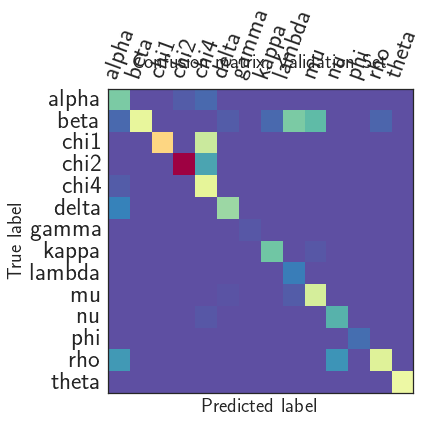

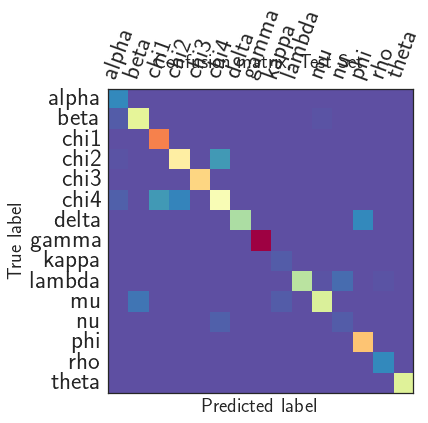

In [99]:

from sklearn.metrics import confusion_matrix
import matplotlib.cm as cmap


fig = plt.figure(figsize=(12,12))

sns.set_style("white") 
unique_labels = np.unique(labels_val)
cm = confusion_matrix(labels_val, labels_rfc, labels=unique_labels)
print(cm)
#print(unique_labels)
ax1 = fig.add_subplot(221)
ax1.matshow(cm, cmap=cmap.Spectral_r);
ax1.set_title('Confusion matrix, Validation Set')
#plt.colorbar()
ax1.set_ylabel('True label')
ax1.set_xlabel('Predicted label')
plt.xticks(range(len(unique_labels)), unique_labels, rotation=70);
plt.yticks(range(len(unique_labels)), unique_labels);
#plt.show()

fig = plt.figure(figsize=(12,12))

sns.set_style("white") 
unique_labels = np.unique(labels_test)
cm = confusion_matrix(labels_test, labels_rfc_test, labels=unique_labels)
print(cm)
#print(unique_labels)
ax1 = fig.add_subplot(221)
ax1.matshow(cm, cmap=cmap.Spectral_r);
ax1.set_title('Confusion matrix, Test Set')
#plt.colorbar()
ax1.set_ylabel('True label')
ax1.set_xlabel('Predicted label')
plt.xticks(range(len(unique_labels)), unique_labels, rotation=70);
plt.yticks(range(len(unique_labels)), unique_labels);
#plt.show()


This is basically copy-pasted from the supervised classification notebook.

In [55]:
import powerspectrum
import copy
import scipy.stats

def plot_misclassifieds(features, trained_labels, real_labels, lc_all, hr_all, hr_limits,
                        nexamples=6, namestr="misclassified", datadir="./"):

    """
    Find all mis-classified light curves and plot them with examples of the real and false classes.
    """
    misclassifieds = []
    for i,(f, lpredict, ltrue, lc, hr) in enumerate(zip(features, trained_labels, real_labels, lc_all, \
                                                hr_all)):
        if lpredict == ltrue:
            continue
        else:
            misclassifieds.append([f, lpredict, ltrue, lc, hr])

    for j,m in enumerate(misclassifieds):
        pos_human = np.random.choice([0,3], p=[0.5, 0.5])
        pos_robot = int(3. - pos_human)

        f = m[0]
        lpredict = m[1]
        ltrue = m[2]
        times = m[3][0]
        counts = m[3][1]
        hr1 = m[4][0]
        hr2 = m[4][1]
        print("Predicted class is: " + str(lpredict))
        print("Human classified class is: " + str(ltrue))
        robot_all = [[lp, lt, lc, hr] for lp, lt, lc, hr in \
                     zip(real_labels, trained_labels, lc_all, hr_all)\
                     if lp == lpredict ]
        human_all = [[lp, lt, lc, hr] for lp, lt, lc, hr in \
                     zip(real_labels, trained_labels, lc_all, hr_all)\
                     if lp == ltrue ]

        np.random.shuffle(robot_all)
        np.random.shuffle(human_all)
        robot_all = robot_all[:6]
        human_all = human_all[:6]

        sns.set_style("darkgrid")
        current_palette = sns.color_palette()
        fig = plt.figure(figsize=(10,15))

        def plot_lcs(times, counts, hr1, hr2, xcoords, ycoords, colspan, rowspan):
            #print("plotting in grid point " + str((xcoords[0], ycoords[0])))
            ax = plt.subplot2grid((9,6),(xcoords[0], ycoords[0]), colspan=colspan, rowspan=rowspan)
            ax.plot(times, counts, lw=2, linestyle="steps-mid", rasterized=True)
            ax.set_xlim([times[0], times[-1]])
            ax.set_ylim([0.0, 12000.0])
            #print("plotting in grid point " + str((xcoords[1], ycoords[1])))

            h, xedges, yedges = np.histogram2d(np.log(hr1), np.log(hr2), bins=40, 
                                   range=hr_limits)
            h = np.rot90(h)
            h = np.flipud(h)

            hmax = np.max(h)
            #print(hmax)
            hmask = np.where(h > hmax/20.)
            hmask1 = np.where(h < hmax/20.)

            hnew = copy.copy(h)
            hnew[hmask[0], hmask[1]] = 1.
            hnew[hmask1[0], hmask1[1]] = 0.0

            ax = plt.subplot2grid((9,6),(xcoords[1], ycoords[1]), colspan=colspan, rowspan=rowspan)
            ax.pcolormesh(xedges,yedges,hnew,cmap='BuPu')
            #ax.scatter(hr1, hr2, facecolor=current_palette[1], edgecolor="none", rasterized=True)
            ax.set_xlim(hr_limits[0])
            ax.set_ylim(hr_limits[1])

            #print("plotting in grid point " + str((xcoords[2], ycoords[2])))    
            ax = plt.subplot2grid((9,6),(xcoords[2], ycoords[2]), colspan=colspan, rowspan=rowspan)
            dt = np.min(np.diff(times))
            ps = powerspectrum.PowerSpectrum(times, counts=counts/dt, norm="rms")
            ps.freq = np.array(ps.freq)
            ps.ps = np.array(ps.ps)*ps.freq
            
            binfreq = np.logspace(np.log10(ps.freq[1]), np.log10(ps.freq[-1]), 24)
            binps, bin_edges, binno = scipy.stats.binned_statistic(ps.freq[1:], ps.ps[1:], statistic="mean", bins=binfreq)

            df = binfreq[1:]-binfreq[:-1]
            binfreq = binfreq[:-1]+df/2.
            ax.loglog(binfreq[1:], binps[1:], linestyle="steps-mid", rasterized=True)
            ax.set_xlim([ps.freq[1], ps.freq[-1]])
            ax.set_ylim([1.e-6, 10.])

            return

        ## first plot misclassified:
        plot_lcs(times, counts, hr1, hr2, [0,0,0], [0,2,4], 2, 2)

        ## now plot examples
        for i in range(4):
            r = robot_all[i]
            h = human_all[i]
            #print(h[0])
            #print("human indices: " + str([ [i+3, i+3, i+3], [pos_human, pos_human+1, pos_human+2]]))
            #print("robot indices: " + str([[i+3, i+3, i+3], [pos_robot, pos_robot+1, pos_robot+2]]))
            plot_lcs(h[2][0], h[2][1], h[3][0], h[3][1], [i+2, i+2, i+2], [pos_human, pos_human+1, pos_human+2], 1, 1)
            plot_lcs(r[2][0], r[2][1], r[3][0], r[3][1], [i+2, i+2, i+2], [pos_robot, pos_robot+1, pos_robot+2], 1, 1)

        ax = plt.subplot2grid((9,6),(8,pos_human+1))
        ax.set_xlim([0,1])
        ax.set_ylim([0,1])
        ax.set_xlabel("Human: %s"%ltrue, fontsize=20)
        ax = plt.subplot2grid((9,6),(8,pos_robot+1))
        ax.set_xlim([0,1])
        ax.set_ylim([0,1])
        ax.set_xlabel("Robot: %s"%lpredict, fontsize=20)
        #plt.show()
        plt.savefig("misclassified%i.pdf"%j, format="pdf")
        plt.close()

Predicted class is: beta
Human classified class is: alpha
Predicted class is: beta
Human classified class is: alpha
Predicted class is: chi2
Human classified class is: alpha
Predicted class is: chi4
Human classified class is: alpha
Predicted class is: beta
Human classified class is: alpha
Predicted class is: beta
Human classified class is: alpha
Predicted class is: gamma
Human classified class is: delta
Predicted class is: gamma
Human classified class is: delta
Predicted class is: gamma
Human classified class is: delta
Predicted class is: gamma
Human classified class is: delta
Predicted class is: gamma
Human classified class is: delta
Predicted class is: gamma
Human classified class is: delta
Predicted class is: gamma
Human classified class is: delta
Predicted class is: gamma
Human classified class is: delta
Predicted class is: beta
Human classified class is: delta
Predicted class is: gamma
Human classified class is: delta
Predicted class is: gamma
Human classified class is: delta
Pred

KeyboardInterrupt: 

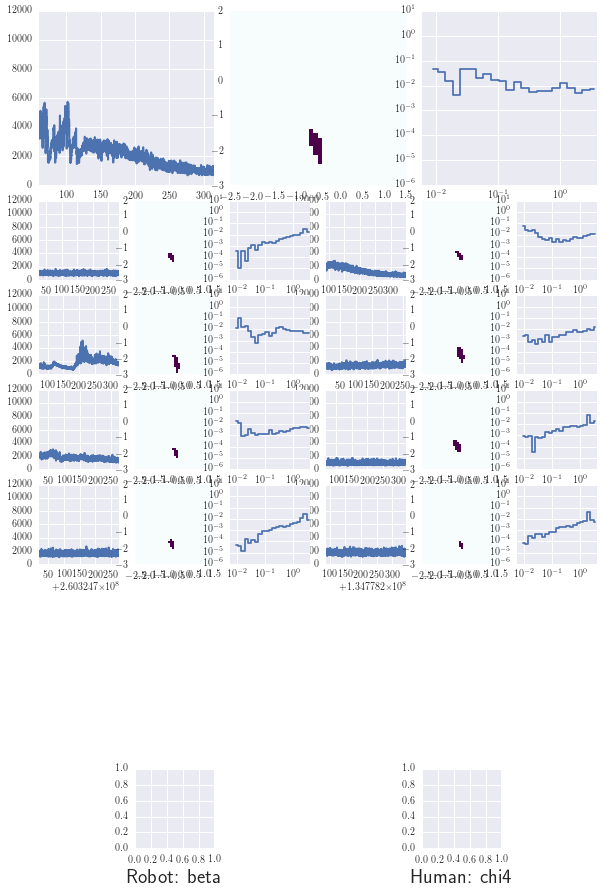

In [56]:
hr2_min = -3.0
hr2_max = 2.0
hr1_min = -2.5
hr1_max = 1.5

sns.set_context("notebook", font_scale=1.0, rc={"axes.labelsize": 14})
plt.rc("font", size=14, family="serif", serif="Computer Sans")
plt.rc("axes", titlesize=14, labelsize=14) 
plt.rc("text", usetex=True)


plot_misclassifieds(features_new_val[:,:15], labels_rfc_red, labels_val, lc_val, hr_val, [[hr1_min, hr1_max],[hr2_min, hr2_max]],
                    nexamples=6, namestr="misclassified", datadir="./")

In [ ]:
for i,(l,lc) in enumerate(zip(labels_val, lc_val)):
    if "chi" in l:
        print(l)
        plt.figure()
        plt.plot(lc_val[:,0], lc_val[:,1])
        plt.savefig("chi%i.pdf"%i, format="pdf")
        plt.close()
        
    else:
        continue

In [31]:
misclassifieds = []
for i,(f, lpredict, ltrue, lc, hr) in enumerate(zip(features_new_val, labels_rfc, labels_val, lc_val, hr_val)):
    if lpredict == ltrue:
        continue
    else:
        misclassifieds.append([f, lpredict, ltrue, lc, hr])


In [55]:
m = misclassifieds[0]
f = m[0]
lpredict = m[1]
ltrue = m[2]
times = m[3][0]
counts = m[3][1]
hr1 = m[4][0]
hr2 = m[4][1]
dt = np.min(np.diff(times))

ps = powerspectrum.PowerSpectrum(times, counts=counts/dt, norm="rms")
ps.freq = np.array(ps.freq)
ps.ps = np.array(ps.ps)*ps.freq

binfreq = np.logspace(np.log10(ps.freq[1]), np.log10(ps.freq[-1]), 24)
binps, bin_edges, binno = scipy.stats.binned_statistic(ps.freq[1:], ps.ps[1:], statistic="mean", bins=binfreq)



## How Gaussian are my features?

For a given class, I want to know how Gaussian my features are, because in the unsupervised part of the project, we're going to use a Gaussian Mixture Model (GMM) to specify the distribution of features into states. We're going to do that for the feature set that we have labels for only.

So, for each state, we're now going to make histograms for each feature in order to gauge its Gaussianity. Double-peaked distributions are okay (these might separate out into separate states, or can be modeled by mixtures), but long-tailed distributions would be bad. 

In [137]:
## combine feature set
features_new_all = np.concatenate((features_new_train[:,:12], features_new_val[:,:12], features_new_test[:,:12]))
labels_all = np.concatenate((labels_train, labels_val, labels_test))
print(features_new_all.shape)

(3024, 12)


In [148]:
## unique set of labels
labels_unique = list(set(labels_all))
print(labels_unique)

feature_names = ["HRCov 01","PC1", "total variance", "maxfreq", "median cr", "PC2", "HR2 mean", "PSDa", "HRCov 00",
                 "mean cr", "HRCov 11", "HRCov 10"]


['phi', 'kappa', 'alpha', 'chi2', 'chi3', 'chi1', 'chi4', 'mu', 'beta', 'rho', 'delta', 'theta', 'nu', 'gamma', 'lambda']


In [172]:

def plot_features(features_new_all, labels_all, feature_names, datadir="./", froot="grs1915_features_"):
    labels_unique = list(set(labels_all))

    for lab in labels_unique:
        fl = np.array([f for f,l in zip(features_new_all, labels_all) if l == lab])

        fig = plt.figure(figsize=(17,13))
        nrows =3
        ncolumns = 4

        sns.set_style("white")

        ax = fig.add_subplot(111)
        # Turn off axis lines and ticks of the big subplot

        ax.spines['top'].set_color('none')
        ax.spines['bottom'].set_color('none')
        ax.spines['left'].set_color('none')
        ax.spines['right'].set_color('none')
        ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')

        sns.set_context("notebook", font_scale=1.5, rc={"axes.labelsize": 16, "text.usetex":True, "font.family":"serif"})
        sns.set_style("darkgrid")
        plt.rc("text", usetex=True)
        plt.rc("axes", titlesize=20, labelsize=20) 
        plt.rc("font", size=24, family="serif", serif="Computer Sans")

        for i,fn in enumerate(feature_names):
            f = fl[:,i]
            ax1 = fig.add_subplot(nrows, ncolumns, i+1)
            ax1.hist(f, bins=15, histtype="stepfilled")
            ax1.set_xlabel(fn)
            #ax1.set_ylabel("p( " + fn + ")")
            #ax1.get_xaxis().set_major_formatter(plt.LogFormatter(10,  labelOnlyBase=False))
            #ax1.get_yaxis().set_major_formatter(plt.LogFormatter(10,  labelOnlyBase=False))

        ax.set_title("Human class: " + lab)
        plt.savefig(datadir+froot+"_%s.pdf"%lab, format="pdf")
        plt.close()
    return

#plot_features(features_new_all, labels_all, feature_names, datadir=datadir)

Inspecting the plots shows that some of the features are asymmetric, and some have several peaks. We're not so worried about multiple peaks; that may be due to classes that separate out in the final classification.
However, asymmetric distributions are a problem if we want to use simple Gaussians to fit the feature space. Thus, let's instead make the log-scale of some of the parameters, the ones that were asymmetric in most classes (inspected by eye).


In [173]:
## these are the features I should be making the log of
logf_ind = [1, 2, 4, 5, 7, 8]

features_log = np.zeros(features_new_all.shape)
for i in range(features_new_all.shape[1]):
    f = features_new_all[:,i]
    if i in logf_ind:
        features_log[:,i] = np.log(f)
    else:
        features_log[:,i] = f
        

In [174]:
plot_features(features_log, labels_all, feature_names, datadir=datadir, froot="grs1915_features_log")